# Sarcasm Detection
 **Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

### LSTM

#### Problem Description:

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected
using hashtag based supervision but such datasets are noisy in terms of labels and
language. Furthermore, many tweets are replies to other tweets and detecting
sarcasm in these requires the availability of contextual tweets.

In this hands-on project, the goal is to build a model to detect whether a sentence
is sarcastic or not, using Bidirectional LSTMs.

#### Data Description:

News Headlines dataset for Sarcasm Detection. The dataset is collected from two
news websites, theonion.com and huffingtonpost.com. This new dataset has the
following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are
no spelling mistakes and informal usage. This reduces the sparsity and also
increases the chance of finding pre-trained embedding.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we
get high-quality labels with much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-
contained. This would help us in teasing apart the real sarcastic elements

##### Content

Each record consists of three attributes:
    - is_sarcastic: 1 if the record is sarcastic otherwise 0
    - headline: the headline of the news article
    - article_link: link to the original news article. Useful in collecting supplementary data

Reference
https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

Proprietary content. ©Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited

#### Steps and tasks:

    1. Read and explore the data
    2. Drop one column
    3. Get length of each sentence
    4. Define parameters
    5. Get indices for words
    6. Create features and labels
    7. Get vocab size
    8. Create a weight matrix using GloVe embeddings
    9. Define and compile a Bidirectional LSTM model
    10.Fit the model and check the validation accuracy

## Install `Tensorflow2.0` 

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.2.0'

## Get Required Files from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#Set your project path 
import os
os.chdir('/content/drive/My Drive/PGPAIML/NLP/Project2/')
print('Working directory changed!')

#verifying the current working directory
cwd = os.getcwd()
print('\nCurrent working directory: ', cwd)

Working directory changed!

Current working directory:  /content/drive/My Drive/PGPAIML/NLP/Project2


In [ ]:
project_path =  ('/content/drive/My Drive/PGPAIML/NLP/Project2/')

#**## Reading and Exploring Data**

## Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data. ( 4 marks)
Hint - As its in json format you need to use pandas.read_json function. Give paraemeter lines = True.

In [ ]:
import pandas as pd
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [ ]:
data.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [ ]:
df_sarcastic = data.is_sarcastic.value_counts().to_frame()
df_sarcastic

,is_sarcastic
0,14985
1,11724


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

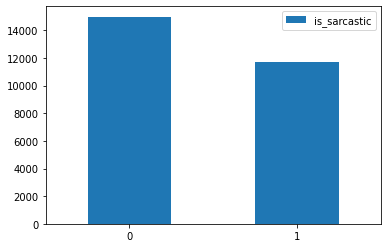

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
df_sarcastic.plot(kind = 'bar')
plt.xticks(rotation = 0)

In [ ]:
sarcastic_headlines = data.loc[data['is_sarcastic'] == 1]
#undersample non sarcastic headline
non_sarcastic_headlines = data.loc[data['is_sarcastic'] == 0].sample(n = 11724, random_state = 25)

In [ ]:
text = ' '.join(review for review in sarcastic_headlines.headline)
print ('There are {} words in the combination of all review.'.format(len(text)))

There are 746098 words in the combination of all review.


In [ ]:
data = pd.concat([sarcastic_headlines, non_sarcastic_headlines])

## Drop `article_link` from dataset. ( 2 marks)
As we only need headline text data and is_sarcastic column for this project. We can drop article link column here.

In [ ]:
data = data.drop(columns = 'article_link', axis = 1)
data.head()

,headline,is_sarcastic
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
8,top snake handler leaves sinking huckabee camp...,1
15,nuclear bomb detonates during rehearsal for 's...,1
16,cosby lawyer asks why accusers didn't come for...,1


## Get the Length of each line and find the maximum length. ( 4 marks)
As different lines are of different length. We need to pad the our sequences using the max length.

In [ ]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
  # Convert words to lower case
  text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
  return text

In [ ]:
import nltk
nltk.download('stopwords')

# Clean the headlines
import re
from nltk.corpus import stopwords 
from pickle import dump, load

clean_balanced_headlines = []
for headline in data['headline']:
  clean_balanced_headlines.append(clean_text(headline, remove_stopwords = False))
print('Data is cleaned!')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Data is cleaned!


In [ ]:
data['cleaned_headline'] = clean_balanced_headlines
data.head()

,headline,is_sarcastic,cleaned_headline
2,mom starting to fear son's web series closest ...,1,mom starting to fear son s web series closest ...
3,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up...
8,top snake handler leaves sinking huckabee camp...,1,top snake handler leaves sinking huckabee camp...
15,nuclear bomb detonates during rehearsal for 's...,1,nuclear bomb detonates during rehearsal for s...
16,cosby lawyer asks why accusers didn't come for...,1,cosby lawyer asks why accusers did not come fo...


In [ ]:
data = data.drop('headline', axis = 1)
data.head()

,is_sarcastic,cleaned_headline
2,1,mom starting to fear son s web series closest ...
3,1,boehner just wants wife to listen not come up...
8,1,top snake handler leaves sinking huckabee camp...
15,1,nuclear bomb detonates during rehearsal for s...
16,1,cosby lawyer asks why accusers did not come fo...


In [ ]:
print (data['cleaned_headline'][7])

this ceo will send your kids to school  if you work for his company


Length of the above headline

In [ ]:
len(data['cleaned_headline'][7].split())

14

In [ ]:
max_length = max([len(headline.split()) for headline in data['cleaned_headline']])
print('Maximum Length: ', max_length)

Maximum Length:  39


#**## Modelling**

## Import required modules required for modelling.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters for the model. ( 2 marks)

In [ ]:
max_features = 10000
maxlen = max_length #39 in this case
embedding_size = 200

## Apply Keras Tokenizer of headline column of your data.  ( 4 marks)
Hint - First create a tokenizer instance using Tokenizer(num_words=max_features) 
And then fit this tokenizer instance on your data column df['headline'] using .fit_on_texts()

In [ ]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(data['cleaned_headline'])

# Define X and y for your model.

In [ ]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 23448
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  119  773    1  869
  235    4 2316  623 4302  215   72   33   40    1 9633]
Number of Labels:  23448
1


## Get the Vocabulary size ( 2 marks)
Hint : You can use tokenizer.word_index.

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  24115


### Word Embedding

## Get Glove Word Embeddings

In [ ]:
glove_file = project_path + "glove.6B.zip"

In [ ]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file as given below.

In [ ]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# Create a weight matrix for words in training docs

In [ ]:
embedding_matrix = np.zeros((vocab_size, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

## Create and Compile your Model  ( 7 marks)
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


In [ ]:
### create the model
model = Sequential()

### Embedding layer for hint 
model.add(Embedding(vocab_size, embedding_size, weights = [embedding_matrix]))

### Bidirectional LSTM layer for hint 
model.add(Bidirectional(LSTM(512, return_sequences = True)))

### dense
model.add(Dense(256, activation = 'relu'))

##dropout
model.add(Dropout(0.5, input_shape = (256,)))

##sigmoid
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         4823000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 1024)        2920448   
_________________________________________________________________
dense (Dense)                (None, None, 256)         262400    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           257       
Total params: 8,006,105
Trainable params: 8,006,105
Non-trainable params: 0
_________________________________________________________________


# Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy ( 5 marks)


In [ ]:
batch_size = 100
epochs = 5

history = model.fit(X, y, batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.2)

Epoch 1/5
188/188 [==============================] - 13s 71ms/step - loss: 0.4512 - accuracy: 0.7947 - val_loss: 0.5793 - val_accuracy: 0.7452
Epoch 2/5
188/188 [==============================] - 12s 64ms/step - loss: 0.2755 - accuracy: 0.8911 - val_loss: 0.5548 - val_accuracy: 0.7652
Epoch 3/5
188/188 [==============================] - 12s 66ms/step - loss: 0.1821 - accuracy: 0.9307 - val_loss: 0.7941 - val_accuracy: 0.7212
Epoch 4/5
188/188 [==============================] - 13s 67ms/step - loss: 0.1308 - accuracy: 0.9533 - val_loss: 0.5672 - val_accuracy: 0.8168
Epoch 5/5
188/188 [==============================] - 13s 68ms/step - loss: 0.0892 - accuracy: 0.9701 - val_loss: 0.5807 - val_accuracy: 0.7796


The validation accuracy at the end of 5th epoch is 0.7796.